# Comparison between real distributions and synthetic distributions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance
from scipy.stats import chisquare, chi2_contingency

import matplotlib.pyplot as plt
import math
from bokeh.io import push_notebook, show, output_notebook, export_png, export_svgs
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
output_notebook()

Loading BokehJS ...

Choice of the synthetic database

In [2]:
conn = sqlite3.connect("snds_Brittany_db0.db")
dpts=["22","35","29","56"]

## Analysis of the synthetic population structure

We start by loading the real population structure from raw data.

In [3]:
import os.path
outdir="../datarep"
pop_saq = pd.read_csv( os.path.join(outdir,"pop.csv") )
pop_tot = pop_saq['pop'].sum()

/home/tguyet/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


And new, we extract the synthetic population structure from the database

In [4]:
# On effectue une requête pour extraire les informations sur la population
df = pd.read_sql_query("SELECT BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN, count(*) FROM IR_BEN_R GROUP BY BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN;", conn)
df.rename(columns={'BEN_SEX_COD':'sex','BEN_RES_DPT':'dpt', 'count(*)':'count'}, inplace=True)
df['age']=2019-df.BEN_NAI_ANN
df=df[['sex','dpt','age','count']]

### Comparison of ages

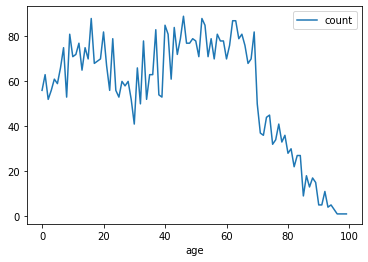

In [5]:
df_age=df.groupby(["age"]).agg({"count":"sum"}).reset_index()
df_age.plot(x='age',y="count")

In [6]:
# Ages are grouped in 5-years group to have the same structure as the real data
age_bins=list(np.arange(0,100,5))
age_bins.append(125)
df_age['bin']=pd.cut(df_age.age,bins=age_bins,include_lowest=True, labels=age_bins[:-1])
df_age_agg=df_age.groupby('bin').agg({"count":"sum"}).reset_index()
df_age_agg.head()

,bin,count
0,0,347
1,5,346
2,10,359
3,15,377
4,20,311


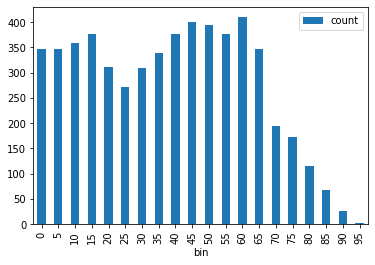

In [7]:
df_age_agg.plot.bar(x='bin',y="count")

In [8]:
#real population (selection of the two generated populations)
pop_seq_dpt=pop_saq[ pop_saq['dpt'].isin(dpts) ].groupby(['age']).agg({'pop':'sum'}).reset_index()
real_pop_size=sum(pop_seq_dpt['pop'])

In [9]:
#the number of patients of the real population is proportionnaly scaled to the level of the synthetic database
ratio = sum(df_age_agg['count'])/sum(pop_seq_dpt['pop'])
pop_seq_dpt['pop'] *= ratio

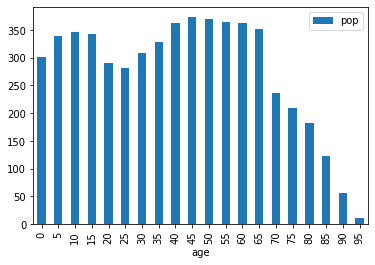

In [10]:
pop_seq_dpt.plot.bar(x="age",y="pop")

In [11]:
# We draw a graph to compare the two distributions
pops=pd.merge(pop_seq_dpt, df_age_agg, left_on="age", right_on="bin")[['age','pop','count']].rename(columns={'count':'pop_sim'})

p = figure(title=None, x_range=(-1,96), y_range=(0,700), plot_width=600, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('age', -0.5, range=p.x_range), top='pop', source=ColumnDataSource(pops), width=1,legend_label="Real")
p.vbar(x=dodge('age', +0.5, range=p.x_range), top='pop_sim', fill_color="orange", width=1, source=ColumnDataSource(pops),legend_label="Synth")
p.legend.location = "top_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

In [12]:
# Compute of the total absolute difference between the two distributions
print( np.sum(np.abs(pops['pop_sim']-pops['pop']))/np.sum(pops['pop']) )
# Compute of the mean absolute difference between the two distributions
print( np.mean(np.abs(pops['pop_sim']-pops['pop'])/pops['pop']) )

0.09237408948824109
0.16242683476400696


### Kolmogorov-Smirnov test
The Kolmogorov-Smirnov test tests whether two one-dimensional distributions differ. 

$D_{n,m}=\max(F_r(x),F_s(x))$ where $F_r$ (resp. $F_s$) is the cumulative distribution function of the real population (resp. synthetic population), and $m$, $n$ are the population sizes (number of samples).

the null hypothesis is rejected at level $\alpha$ (ie it really differs) if the difference is above a critical value:
$$D_{n,m}>c(\alpha)\sqrt{\frac{n + m}{n\cdot m}}$$

where $c\left(\alpha\right)=\sqrt{-\ln\left(\tfrac{\alpha}{2}\right)\cdot \tfrac{1}{2}}$.

<br>

In the following, we use $n=m$ equals to the size of the sampled database. 


In [13]:
# Cumulative distribution functions
P_r = pops['pop'].to_numpy()/pops['pop'].sum()
CDF_r = np.cumsum(P_r)
P_s = pops['pop_sim'].to_numpy()/pops['pop_sim'].sum()
CDF_s = np.cumsum(P_s)

In [14]:
#Implementation of the Kolmogorov-Smirnov test
alpha=0.05 #95% critical value 
m=sum(df_age_agg['count'])
n=real_pop_size
statistic=np.max(np.abs(CDF_r-CDF_s))
critical_value= np.sqrt(-np.log(alpha/2)*0.5)*np.sqrt( (n+m)/(m*m) )
print(statistic>critical_value)
print(statistic)
print(critical_value)

False
0.04428458692968196
0.44624860134423544


We conclude that the distributions are not significantly different (p<0.05).

### KL Divergence / JS divergence

Kullback-Leibler (KL) Divergence is a measure based on entropy to compare two distributions $P$ and $P$. The Jensen-Shannon is the symmetric version of KL divergence.

$$D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$$

and 
$$D_\text{JS}(P \parallel Q) = \frac{1}{2}D_\text{KL}(P \parallel Q) + \frac{1}{2}D_\text{KL}(Q \parallel P)$$

In [15]:
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))
 
# calculate the js divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

Then, we simply have to apply the function on our distributions



In [16]:
js_divergence(pops['pop'].to_numpy()/pops['pop'].sum(), pops['pop_sim'].to_numpy()/pops['pop_sim'].sum())

0.004356938140303161

### Wasserstein distance (Earth's mover distance)

In [17]:
wasserstein_distance(pops['pop'].to_numpy()/pops['pop'].sum(), pops['pop_sim'].to_numpy()/pops['pop_sim'].sum())

0.00451847581229106

## Now ... the same for genders


In [18]:
df_sex=df.groupby(["sex"]).agg({"count":"sum"}).reset_index()
df_sex

,sex,count
0,1,2635
1,2,2904


In [19]:
pop_sex_dpt=pop_saq[pop_saq['dpt'].isin(dpts)].groupby(['sex']).agg({'pop':'sum'}).reset_index()
pop_sex_dpt

,sex,pop
0,1,1.606014e+06
1,2,1.700917e+06


In [20]:
#same proportion for figures
pop_sex_dpt['pop'] = ratio*pop_sex_dpt['pop']
pops_sex=pd.merge(pop_sex_dpt,df_sex,on='sex').rename(columns={"count":"pop_sim"})

In [21]:
pops_sex['sex']=pops_sex['sex'].astype("str").str.replace("1","M").replace("2","F")
p = figure(title=None, x_range=pops_sex['sex'].to_numpy(), plot_width=400, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('sex', -0.2, range=p.x_range), top='pop', source=ColumnDataSource(pops_sex), width=0.4,legend_label="Real")
p.vbar(x=dodge('sex', +0.2, range=p.x_range), top='pop_sim', fill_color="orange", width=0.4, source=ColumnDataSource(pops_sex),legend_label="Synth")
p.legend.location = "bottom_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

### Quantitiative Comparisons

We perform $\chi^2$ test, and then we compute some distances.

In [22]:
chisquare(pops_sex['pop_sim'].to_numpy(), pops_sex['pop'].to_numpy())

Power_divergenceResult(statistic=2.187962244669645, pvalue=0.1390932274584621)

Here, the p-value is >0.05, then the null hypotheses (i.e. $H_0$: the two samples have the distribution) can not be rejected.

We simply compute the JS divergence in this case (not a continuous distribution)

In [23]:
js_divergence(pops_sex['pop'].to_numpy()/pops_sex['pop'].sum(), pops_sex['pop_sim'].to_numpy()/pops_sex['pop_sim'].sum())

7.128382603588564e-05

In [24]:
wasserstein_distance(pops_sex['pop'].to_numpy()/pops_sex['pop'].sum(), pops_sex['pop_sim'].to_numpy()/pops_sex['pop_sim'].sum())

0.009933340490130171

### Mean values of KL divergence

In [25]:
age_bins=list(np.arange(0,100,5))
age_bins.append(125)

js_age_vals=[]
js_sex_vals=[]
for i in range(10):
    conni = sqlite3.connect("snds_Brittany_db%d.db"%i)
    df = pd.read_sql_query("SELECT BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN, count(*) FROM IR_BEN_R GROUP BY BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN;", conni)
    df.rename(columns={'BEN_SEX_COD':'sex','BEN_RES_DPT':'dpt', 'count(*)':'count'}, inplace=True)
    df['age']=2019-df.BEN_NAI_ANN
    df=df[['sex','dpt','age','count']]
    
    #ages
    df['bin']=pd.cut(df.age,bins=age_bins,include_lowest=True, labels=age_bins[:-1])
    df_age_agg=df.groupby('bin').agg({"count":"sum"}).reset_index()
    
    pop_seq_dpt=pop_saq[ pop_saq['dpt'].isin(dpts) ].groupby(['age']).agg({'pop':'sum'}).reset_index()
    
    pops=pd.merge(pop_seq_dpt, df_age_agg, left_on="age", right_on="bin")[['age','pop','count']].rename(columns={'count':'pop_sim'})
    js=js_divergence(pops['pop'].to_numpy()/pops['pop'].sum(), pops['pop_sim'].to_numpy()/pops['pop_sim'].sum())
    js_age_vals.append(js)
    
    df_sex=df.groupby(["sex"]).agg({"count":"sum"}).reset_index()
    pop_sex_dpt=pop_saq[pop_saq['dpt'].isin(dpts)].groupby(['sex']).agg({'pop':'sum'}).reset_index()
    pops_sex['sex']=pops_sex['sex'].astype("str").str.replace("1","M").replace("2","F")
    js=js_divergence(pops_sex['pop'].to_numpy()/pops_sex['pop'].sum(), pops_sex['pop_sim'].to_numpy()/pops_sex['pop_sim'].sum())
    js_sex_vals.append(js)

    conni.close()
print(js_age_vals)
print("mean: %.2e, var: %.2e"%(np.mean(js_age_vals),np.var(js_age_vals)))
print(js_sex_vals)
print("mean: %.2e, var: %.2e"%(np.mean(js_sex_vals),np.var(js_sex_vals)))

[0.004356938140303201, 0.004420882702350876, 0.004603420481545648, 0.005024881232192281, 0.004465286450194141, 0.004366303290896521, 0.004313796599946898, 0.004570617246476349, 0.004324293724660682, 0.004737253741472602]
mean: 4.52e-03, var: 4.55e-08
[7.128382603588564e-05, 7.128382603588564e-05, 7.128382603588564e-05, 7.128382603588564e-05, 7.128382603588564e-05, 7.128382603588564e-05, 7.128382603588564e-05, 7.128382603588564e-05, 7.128382603588564e-05, 7.128382603588564e-05]
mean: 7.13e-05, var: 0.00e+00


## Analysis of the drug distributions

In [26]:
# On effectue une requête pour extraire les informations sur les médicaments (nombres de prescriptions par ATC 3)
# -> là on a les chiffres généré pour 2 départements, sur 1 an
df = pd.read_sql_query("SELECT PHA_ATC_C03, sum(PHA_ACT_QSN) FROM er_pha_f JOIN ir_pha_r ON ir_pha_r.PHA_CIP_C13=er_pha_f.PHA_PRS_C13 GROUP BY PHA_ATC_C03;", conn)
df.rename(columns={'PHA_ATC_C03':'ATC2','sum(PHA_ACT_QSN)':'nb'}, inplace=True)
df

,ATC2,nb
0,A01,1574
1,A02,7618
2,A03,3014
3,A04,556
4,A05,132
...,...,...
73,S02,383
74,V01,37
75,V03,92
76,V04,27


In [27]:
# data for the French population, during a year
data = pd.read_csv("../data/OPEN_MEDIC_2019.zip", header=0, sep=';', encoding="latin_1")[['ATC2','BOITES']]
data = data.groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})

In [28]:
data.head()

,ATC2,nb
0,A01,22941566
1,A02,100746397
2,A03,48505314
3,A04,8452671
4,A05,1954634


In [29]:
#we compute the population proportionality ratio
ratio = sum( df_age_agg['count'] )/pop_tot

In [30]:
df_cmp=pd.merge(data,df,how="left",on='ATC2',suffixes=('','_sim')).fillna(0)
df_cmp['nb'] *= ratio
df_cmp.head()

,ATC2,nb,nb_sim
0,A01,1914.922384,1574.0
1,A02,8409.257273,7618.0
2,A03,4048.717142,3014.0
3,A04,705.540716,556.0
4,A05,163.152437,132.0


In [31]:
p = figure(title=None, x_range=df_cmp['ATC2'].to_numpy(), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ATC2', -0.2, range=p.x_range), top='nb_sim', fill_color="orange", width=0.4, source=ColumnDataSource(df_cmp),legend_label="Synth")
p.vbar(x=dodge('ATC2', +0.2, range=p.x_range), top='nb', source=ColumnDataSource(df_cmp), width=0.4,legend_label="Real")
p.legend.location = "top_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

### Quantitiative Comparisons

We perform $\chi^2$ test, and then a compute some distances.

In [32]:
chisquare(df_cmp['nb_sim'].to_numpy(), df_cmp['nb'].to_numpy())

Power_divergenceResult(statistic=4455.207977025794, pvalue=0.0)

Here, the p-value is null, then the null hypotheses (i.e. $H_0$: the two samples have the distribution) is rejected.

We now simply compute the JS divergence in this case (not a continuous distribution)

In [33]:
js_divergence(df_cmp['nb'].to_numpy()/df_cmp['nb'].sum(), df_cmp['nb_sim'].to_numpy()/df_cmp['nb_sim'].sum())

<ipython-input-15-953c0830fea7>:3: RuntimeWarning: divide by zero encountered in log
  return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))
<ipython-input-15-953c0830fea7>:3: RuntimeWarning: invalid value encountered in double_scalars
  return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))


nan

In [34]:
wasserstein_distance(df_cmp['nb'].to_numpy()/df_cmp['nb'].sum(), df_cmp['nb_sim'].to_numpy()/df_cmp['nb_sim'].sum())

0.0009889107111981398

In [35]:
# Compute of the total absolute difference between the two distributions
print( np.sum(np.abs(df_cmp['nb_sim']-df_cmp['nb']))/np.sum(df_cmp['nb']) )
# Compute of the mean absolute difference between the two distributions
print( np.mean(np.abs(df_cmp['nb_sim']-df_cmp['nb'])/df_cmp['nb']) )

0.10312596029704404
0.18547769176184906


### Mean KL divergence

In [36]:
data = pd.read_csv("../data/OPEN_MEDIC_2019.zip", header=0, sep=';', encoding="latin_1")[['ATC2','BOITES']]
data = data.groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})

js_vals=[]
for i in range(10):
    conni = sqlite3.connect("snds_Brittany_db%d.db"%i)
    df = pd.read_sql_query("SELECT PHA_ATC_C03, sum(PHA_ACT_QSN) FROM er_pha_f JOIN ir_pha_r ON ir_pha_r.PHA_CIP_C13=er_pha_f.PHA_PRS_C13 GROUP BY PHA_ATC_C03;", conni)
    df.rename(columns={'PHA_ATC_C03':'ATC2','sum(PHA_ACT_QSN)':'nb'}, inplace=True)
    df_cmp=pd.merge(data,df,how="left",on='ATC2',suffixes=('','_sim')).fillna(0)
    df_cmp=df_cmp[df_cmp['nb_sim']!=0]
    
    js=js_divergence(df_cmp['nb'].to_numpy()/df_cmp['nb'].sum(), df_cmp['nb_sim'].to_numpy()/df_cmp['nb_sim'].sum())
    
    js_vals.append(js)
    conni.close()
print(js_vals)
print("mean: %.2e, var: %.2e"%(np.mean(js_vals),np.var(js_vals)))

[0.004256684087469983, 0.003938747505275751, 0.0040126153389123155, 0.004065690977919667, 0.003942539896471847, 0.004179296044895158, 0.003684526187509506, 0.004086835399582545, 0.003997700157755514, 0.004029162123631213]
mean: 4.02e-03, var: 2.14e-08


In [37]:
df_cmp[df_cmp['nb_sim']!=0]

,ATC2,nb,nb_sim
0,A01,22941566,1503.0
1,A02,100746397,7081.0
2,A03,48505314,2970.0
3,A04,8452671,517.0
4,A05,1954634,149.0
...,...,...,...
74,S02,5741148,339.0
75,V01,448942,25.0
76,V03,1403824,96.0
77,V04,520717,33.0


## Analysis of medical technical procedures

In [38]:
# Database query to extract procedures from the synthetic database
df = pd.read_sql_query("SELECT CAM_PRS_IDE, CAM_PRS_RGT, count(*) FROM er_cam_f JOIN ir_ccam_v63 ON er_cam_f.CAM_PRS_IDE=ir_ccam_v63.CAM_PRS_IDE_COD GROUP BY CAM_PRS_IDE, CAM_PRS_RGT;", conn)
df.rename(columns={'CAM_PRS_IDE':'ccam','CAM_PRS_RGT':'grp','count(*)':'nb'}, inplace=True)
df.head()

,ccam,grp,nb
0,ACQH001,ADI,1
1,ACQH002,ADI,1
2,ACQH003,ADI,13
3,ACQJ001,ADI,1
4,ACQJ002,ADI,37


In [39]:
procedures = pd.read_excel("../data/Actes_techniques_de_la_CCAM_en_2016.xls", sheet_name='Panorama des actes CCAM')
procedures.rename(columns={"Code Acte":'ccam',"Code Regroupement":"grp", "Quantité d'actes ":"nb"}, inplace=True)
procedures=procedures.groupby(['ccam',"grp"]).agg({"nb":"sum"}).reset_index()

In [40]:
#selection of procedures that are actually used in our simulation
#procedures=procedures[ (procedures['grp']=="ADC") | (procedures['grp']=="ACO") |(procedures['grp']=="ADA") |(procedures['grp']=="ADE") |(procedures['grp']=="ADI") |(procedures['grp']=="ADT") ]
procedures=procedures[ (procedures['grp']=="ADC") | (procedures['grp']=="ACO") |(procedures['grp']=="ADE") |(procedures['grp']=="ADI") |(procedures['grp']=="ADT") ]
procedures=procedures[ (procedures['ccam'].str[:2]!="HB") ]

In [41]:
procedures.head()

,ccam,grp,nb
1,AAFA001,ADC,103
3,AAFA002,ADC,446
5,AAFA003,ADC,9
7,AAFA005,ADC,9
9,AAFA006,ADC,2


In [42]:
procs_tot=procedures.groupby(['ccam']).agg({"nb":"sum"}).reset_index()

In [43]:
procs_tot.head()

,ccam,nb
0,AAFA001,103
1,AAFA002,446
2,AAFA003,9
3,AAFA005,9
4,AAFA006,2


In [44]:
procs_tot['nb'] *= ratio

In [45]:
procs_tot.head()

,ccam,nb
0,AAFA001,0.008597
1,AAFA002,0.037227
2,AAFA003,0.000751
3,AAFA005,0.000751
4,AAFA006,0.000167


### Comparison of the distribution of procedures per groups

In [46]:
procs_grp=procedures.groupby(['grp']).agg({"nb":"sum"}).reset_index()
procs_grp['nb'] *= ratio

In [47]:
df_grp=df.groupby("grp").agg({"nb":"sum"}).reset_index()

Text(0, 0.5, 'nb')

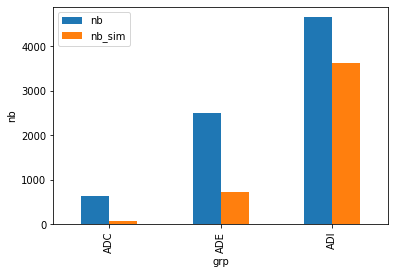

In [48]:
grps=pd.merge(procs_grp, df_grp,on="grp", suffixes=('','_sim'))

fig, axs = plt.subplots()
grps.set_index("grp").plot.bar(ax=axs)
axs.set_ylabel("nb")

In [49]:
procs_ccam=procedures.groupby(['ccam']).agg({"nb":"sum"}).reset_index()
procs_ccam['nb'] *= ratio
#procs_ccam['nb'] = procs_ccam['nb'].astype(int)
df_ccam=df.groupby("ccam").agg({"nb":"sum"}).reset_index()
ccams=pd.merge(procs_ccam, df_ccam, on="ccam", suffixes=('','_sim'))

In [50]:
p = figure(title=None, x_range=ccams['ccam'].to_numpy(), y_range=(0,1200), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ccam', -0.2, range=p.x_range), top='nb', source=ColumnDataSource(ccams), width=0.4,legend_label="Real")
p.vbar(x=dodge('ccam', +0.2, range=p.x_range), top='nb_sim', fill_color="orange", width=0.4, source=ColumnDataSource(ccams),legend_label="Synth")
p.legend.location = "top_left"
#p.xaxis.axis_label = 'CCAM procedures'
p.yaxis.axis_label = 'Nb'
show(p)

In [51]:
p = figure(title=None, x_range=ccams['ccam'][ (ccams['ccam']>="NFKA008") & (ccams['ccam']<="QEQK005") ].to_numpy(), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ccam', -0.2, range=p.x_range), top='nb', source=ColumnDataSource(ccams), width=0.4,legend_label="Real")
p.vbar(x=dodge('ccam', +0.2, range=p.x_range), top='nb_sim', fill_color="orange", width=0.4, source=ColumnDataSource(ccams),legend_label="Synth")
p.legend.location = "top_left"
#p.xaxis.axis_label = 'CCAM procedures'
p.yaxis.axis_label = 'Nb'
show(p)

### Quantitiative Comparisons

We perform $\chi^2$ test, and then a compute some distances.

In [52]:
chisquare(ccams['nb_sim'][ (ccams['nb_sim']>5) & (ccams['nb']>5) & (ccams['ccam']>="NFKA008") & (ccams['ccam']<="NGQK002") ].to_numpy(), ccams['nb'][ (ccams['nb_sim']>5) & (ccams['nb']>5) & (ccams['ccam']>="NFKA008") & (ccams['ccam']<="NGQK002") ].to_numpy(), ddof=1)

Power_divergenceResult(statistic=31.805278124652393, pvalue=2.0966509016075656e-06)

Here, the $p$-value is null, then the null hypotheses (i.e. $H_0$: the two samples have the distribution) is rejected.

We now simply compute the JS divergence in this case (not a continuous distribution)

In [53]:
js_divergence(ccams['nb'].to_numpy()/ccams['nb'].sum(), ccams['nb_sim'].to_numpy()/ccams['nb_sim'].sum())

0.04540202491160743

In [54]:
wasserstein_distance(ccams['nb'].to_numpy()/ccams['nb'].sum(), ccams['nb_sim'].to_numpy()/ccams['nb_sim'].sum())

0.0004518950575312791

In [55]:
# Compute of the total absolute difference between the two distributions
print( np.sum(np.abs(ccams['nb_sim']-ccams['nb']))/np.sum(ccams['nb']) )
# Compute of the mean absolute difference between the two distributions
print( np.mean(np.abs(ccams['nb_sim']-ccams['nb'])/ccams['nb']) )

0.4161264236987232
2.7442594910472167


### Mean KL divergence

In [56]:
procedures = pd.read_excel("../data/Actes_techniques_de_la_CCAM_en_2016.xls", sheet_name='Panorama des actes CCAM')
procedures.rename(columns={"Code Acte":'ccam',"Code Regroupement":"grp", "Quantité d'actes ":"nb"}, inplace=True)
procedures=procedures[ (procedures['grp']=="ADC") | (procedures['grp']=="ACO") |(procedures['grp']=="ADE") |(procedures['grp']=="ADI") |(procedures['grp']=="ADT") ]
procedures=procedures[ (procedures['ccam'].str[:2]!="HB") ]
procs_ccam=procedures.groupby(['ccam']).agg({"nb":"sum"}).reset_index()

js_vals=[]
for i in range(10):
    conni = sqlite3.connect("snds_Brittany_db%d.db"%i)
    df = pd.read_sql_query("SELECT CAM_PRS_IDE, CAM_PRS_RGT, count(*) FROM er_cam_f JOIN ir_ccam_v63 ON er_cam_f.CAM_PRS_IDE=ir_ccam_v63.CAM_PRS_IDE_COD GROUP BY CAM_PRS_IDE, CAM_PRS_RGT;", conni)
    df.rename(columns={'CAM_PRS_IDE':'ccam','CAM_PRS_RGT':'grp','count(*)':'nb'}, inplace=True)
    df_ccam=df.groupby("ccam").agg({"nb":"sum"}).reset_index()
    ccams=pd.merge(procs_ccam, df_ccam, on="ccam", suffixes=('','_sim'))
    js=js_divergence(ccams['nb'].to_numpy()/ccams['nb'].sum(), ccams['nb_sim'].to_numpy()/ccams['nb_sim'].sum())
    js_vals.append(js)
    conni.close()
print(js_vals)
print("mean: %.2e, var: %.2e"%(np.mean(js_vals),np.var(js_vals)))

[0.045402024911607455, 0.051106238080038086, 0.04339915022792285, 0.04542304443399771, 0.04235728934358842, 0.04891123804051785, 0.04647097213141391, 0.04954112982086515, 0.0403210245307285, 0.04261943111058985]
mean: 4.56e-02, var: 1.10e-05
